# 1. Presets

1. Visualize CUDA if GPU is used. May be cause of malfunctioning GPU training if CUDA version and tensorflow version do not match.
2. Install tensorflow nightly to ensure latest changes are installed. This might be needed for the micro and lite parts of tensorflow which are under development.
3. Download tensorflow models if not already in path
4. Install object detection API

In [ ]:
!nvcc --version

In [ ]:
!pip install --user tf-nightly

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
# Clone the tensorflow models repository if it doesn't already exist

import os
import pathlib

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Install the Object Detection API
%cd models/research/
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install --user .

# 2. Download and prepare dataset

Download the 2017 [MSCOCO](https://cocodataset.org/#home) dataset. The download script focus only on person annotations and images since we want to train for person detection only.
The script skips download if the .zip-file already exists. Unzip is skipped if the folder already exists. This file is supplied via the git repository and must be moved into the tensorflow models subdirectory.

In [ ]:
# Download coco dataset and prepare records
%cd ~/sparky-rooms/tensorflow-model/
# Move custom download script to corresponding location to execute
%mv download_and_preprocess_mscoco_person.sh models/research/object_detection/dataset_tools/
# Go to root of sources
%cd models/research/
# Download and unzip to data/mscoco if not already existing
!bash object_detection/dataset_tools/download_and_preprocess_mscoco_person.sh ~/data/mscoco

# 3. Training

Reference configured pipeline from git repository and assign output directory of the training. The checkpoint of the resulting detection model is located here. This checkpoint is later used to test the inference.

## 3.1 Run training

In [ ]:
CONFIG="sparky-rooms/tensorflow-model/pipeline.config"
MODEL_OUT="sparky-rooms/tensorflow-model/sparky"

In [ ]:
# Run training
%cd ~
!python sparky-rooms/tensorflow-model/models/research/object_detection/model_main_tf2.py \
--model_dir=$MODEL_OUT \
--num_train_steps=10000000 \
--sample_1_of_n_eval_examples=1 \
--pipeline_config_path=$CONFIG \
--alsologtostderr

## 3.2 Test resulting checkpoint inference

In [ ]:
# How many results should be printed:
SLICE=10
# Checkpoint to load
CHK='ckpt-2'

In [ ]:
from IPython.display import display

import io
import os
import numpy as np
from PIL import Image
import tensorflow as tf

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file("/home/jupyter/"+CONFIG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join("/home/jupyter/"+MODEL_OUT, CHK)) # Can vary

# Load image for inference testing 
image = Image.open('/home/jupyter/data/test3.jpg').resize((320,320))
display(image)

image_data = np.asarray(image)
image_data = image_data.astype(np.float32)

# Feed as input
input_data = np.asarray([image_data])
input_data = tf.convert_to_tensor(input_data, dtype=tf.float32)

# Run inference
image, shapes = detection_model.preprocess(input_data)
prediction_dict = detection_model.predict(input_data, shapes)
detections = detection_model.postprocess(prediction_dict, shapes)

# Results
print('Shopwing first {} Results:'.format(SLICE))
print("Detection Scores:")
print(detections['detection_scores'][0][:SLICE].numpy())
print("Detection Classes:")
print(detections['detection_classes'][0][:SLICE].numpy())
print("Detection Boxes:")
print(detections['detection_boxes'][0][:SLICE].numpy())

# 4. Export model

Export the model from checkpoint to .pb (freeze graph). Then convert the frozen graph into .tflite.

In [ ]:
RESULTS="sparky/results"
MODEL_NO_QUANT_TFLITE="sparky/results/model_no_quant.tflite"
MODEL_MICRO="sparky/results/model.cc"

In [ ]:
%cd ~
# Export checkpoint to .pb
!python sparky-rooms/tensorflow-model/models/research/object_detection/exporter_main_v2.py \
--pipeline_config_path=$CONFIG \
--trained_checkpoint_dir=$MODEL_OUT \
--output_directory=$RESULTS \
--input_type image_tensor

In [ ]:
# Alternative
%cd ~
# Export checkpoint to .pb - file name "export_tflite_graph_tf2" is missleading. This generates a .pb file which can be converted into tflite.
!python sparky-rooms/tensorflow-model/models/research/object_detection/export_tflite_graph_tf2.py \
--pipeline_config_path=$CONFIG \
--trained_checkpoint_dir=$MODEL_OUT \
--output_directory=$RESULTS 

In [ ]:
import tensorflow as tf

# Convert .pb to .Lite
converter = tf.lite.TFLiteConverter.from_saved_model("/home/jupyter/"+RESULTS+"/saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.allow_custom_ops = True
model_no_quant_tflite = converter.convert()

open("/home/jupyter/"+MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# 5. Test converted tflite model


Expected input shape:  [  1 300 300   3]
Expected output shape:  [ 1 10  4]
Prepare image...
(1, 300, 300, 3)
Set input...
Invoke inference...
Finished inference...
Categories:
[{'id': 1, 'name': 'person'}]


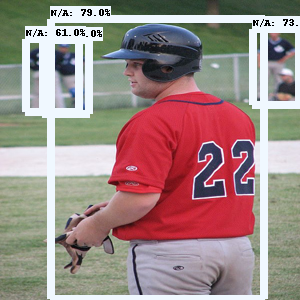

Result:
[10.]
[[[0.06580314 0.16973948 0.99650836 0.8811487 ]
  [0.09795125 0.84249896 0.34816098 0.9985886 ]
  [0.13550225 0.14276743 0.37792626 0.29885706]
  [0.13291526 0.08623322 0.37153774 0.26336163]
  [0.21433204 0.20891534 0.36032373 0.2915599 ]
  [0.24036103 0.91537887 0.3434742  0.9967274 ]
  [0.19566241 0.03590129 0.3873569  0.26709864]
  [0.2798211  0.21627475 0.373605   0.28573036]
  [0.12195145 0.07751119 0.28822803 0.2877908 ]
  [0.21683928 0.6939679  0.23467866 0.7180559 ]]]
[[ 0  0  0  0  0  0  0  0  0 36]]
[[0.78515625 0.73046875 0.609375   0.609375   0.37890625 0.35546875
  0.33203125 0.3125     0.3125     0.30078125]]


In [16]:
import numpy as np
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt

from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import label_map_util

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/home/jupyter/"+MODEL_NO_QUANT_TFLITE)
#interpreter = tf.lite.Interpreter(model_path="/home/jupyter/ssd_mobilenet_v1_1_metadata_1.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
output_shape = output_details[0]['shape']

print("Expected input shape: ", input_shape)
print("Expected output shape: ", output_shape)

# Load test image
print("Prepare image...")
image = Image.open('/home/jupyter/data/test3.jpg').resize((300,300))
image_data = np.asarray(image)
#image_data = image_data.astype(np.float32)

# Feed as input
input_data = np.asarray([image_data])
print(input_data.shape)
print("Set input...")
tensor_index = input_details[0]['index']
#input_tensor = interpreter.tensor(tensor_index)()[0]
#input_tensor[:, :] = input_data
interpreter.set_tensor(tensor_index, input_data)

print("Invoke inference...")
# Inference
interpreter.invoke()
print("Finished inference...")

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
# Get output data
detection_boxes = interpreter.get_tensor(output_details[0]['index'])
detection_classes = interpreter.get_tensor(output_details[1]['index']).astype(np.int32)
detection_scores = interpreter.get_tensor(output_details[2]['index'])
num_boxes = interpreter.get_tensor(output_details[3]['index'])

label_map = label_map_util.load_labelmap("/home/jupyter/sparky-rooms/tensorflow-model/label_map.pbtxt")
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=10, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

print("Categories:")
print(categories)

image_infered = vis_util.visualize_boxes_and_labels_on_image_array(
    image_data.copy(),
    np.squeeze(detection_boxes),
    np.squeeze(detection_classes),
    np.squeeze(detection_scores),
    category_index,
    use_normalized_coordinates=True,
    line_thickness=8)

display(Image.fromarray(image_infered))

print("Result:")
print(num_boxes)
print(detection_boxes)
print(detection_classes)
print(detection_scores)

# 6. Create final output

Convert to binary C array which can be loaded onto a arduino board if its size is small enough.

In [17]:
# Convert to a C source file
%cd ~
!apt-get update && apt-get -qq install xxd
!xxd -i {MODEL_NO_QUANT_TFLITE} > {MODEL_MICRO}
REPLACE_TEXT = MODEL_NO_QUANT_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_MICRO}

/home/jupyter
Reading package lists... Done
W: chmod 0700 of directory /var/lib/apt/lists/partial failed - SetupAPTPartialDirectory (1: Operation not permitted)
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
